# 模型评估脚本

本 Notebook 用于加载训练好的模型，并在测试集上进行评估和可视化。

In [2]:
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# 将项目根目录添加到路径中
sys.path.append(os.path.abspath('.'))

from config import Config
from data.dataloader import get_test_dataloader
from models.simple_cnn import SimpleCNN

# 设置绘图风格
sns.set_theme(style="whitegrid")
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

In [3]:
# 1. 初始化配置
cfg = Config()
print(f"Using device: {cfg.device}")

# 2. 加载测试数据
try:
    test_loader = get_test_dataloader(cfg)
    print(f"Test dataset size: {len(test_loader.dataset)}")
    
    # 获取类别名称
    class_to_idx = test_loader.dataset.class_to_idx
    idx_to_class = {v: k for k, v in class_to_idx.items()}
    classes = [idx_to_class[i] for i in range(len(idx_to_class))]
    print(f"Classes: {classes}")
except Exception as e:
    print(f"Error loading data: {e}")
    # 如果没有 testing.txt，可能需要手动指定或使用验证集代替演示
    print("Trying to use validation set instead for demonstration if testing.txt is missing...")
    from data.dataloader import get_dataloaders
    _, test_loader = get_dataloaders(cfg)
    print(f"Loaded validation set as test set. Size: {len(test_loader.dataset)}")
    class_to_idx = test_loader.dataset.class_to_idx
    idx_to_class = {v: k for k, v in class_to_idx.items()}
    classes = [idx_to_class[i] for i in range(len(idx_to_class))]

if len(classes) != cfg.num_classes:
	raise ValueError(f"❌ error: Number of classes in data ({len(classes)}) does not match config ({cfg.num_classes}).")

Using device: cpu
   Loaded 594 samples from testing.txt
Test dataset size: 594
Classes: ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise']


In [4]:
# 3. 加载模型
# 请在这里修改为您想要评估的模型路径
model_path = "experiments/trained_models/SimpleCNN_20251127_174707.pth" 

# 初始化模型
model = SimpleCNN(cfg)

# 加载权重
if os.path.exists(model_path):
    state_dict = torch.load(model_path, map_location=cfg.device)
    model.load_state_dict(state_dict)
    model.to(cfg.device)
    model.eval()
    print(f"✅ Model loaded successfully from {model_path}")
else:
    print(f"❌ Model file not found: {model_path}")
    raise FileNotFoundError("Model file not found")

✅ Model loaded successfully from experiments/trained_models/SimpleCNN_20251127_174707.pth


In [5]:
# 4. 进行预测
all_preds = []
all_targets = []

print("Running predictions on test set...")
with torch.no_grad():
    for batch in test_loader:
        if isinstance(batch, dict):
            inputs, targets = batch["inputs"], batch["labels"]
        else:
            inputs, targets = batch[0], batch[1]
            
        inputs = inputs.to(cfg.device)
        targets = targets.to(cfg.device)
        
        outputs = model(inputs)
        preds = outputs.argmax(dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

print("Prediction complete.")

Running predictions on test set...
Prediction complete.
Prediction complete.


In [6]:
# 5. 评估结果

# 计算准确率
accuracy = np.mean(np.array(all_preds) == np.array(all_targets))
print(f"Overall Accuracy: {accuracy:.4f}")

# 打印详细分类报告
print("\nClassification Report:")
print(classification_report(all_targets, all_preds, target_names=classes))

Overall Accuracy: 0.2929

Classification Report:
              precision    recall  f1-score   support

       anger       0.16      0.04      0.06        99
     disgust       0.31      0.24      0.27        99
        fear       0.22      0.10      0.14        99
         joy       0.38      0.28      0.33        99
     sadness       0.26      0.71      0.38        99
    surprise       0.38      0.38      0.38        99

    accuracy                           0.29       594
   macro avg       0.29      0.29      0.26       594
weighted avg       0.29      0.29      0.26       594

              precision    recall  f1-score   support

       anger       0.16      0.04      0.06        99
     disgust       0.31      0.24      0.27        99
        fear       0.22      0.10      0.14        99
         joy       0.38      0.28      0.33        99
     sadness       0.26      0.71      0.38        99
    surprise       0.38      0.38      0.38        99

    accuracy                

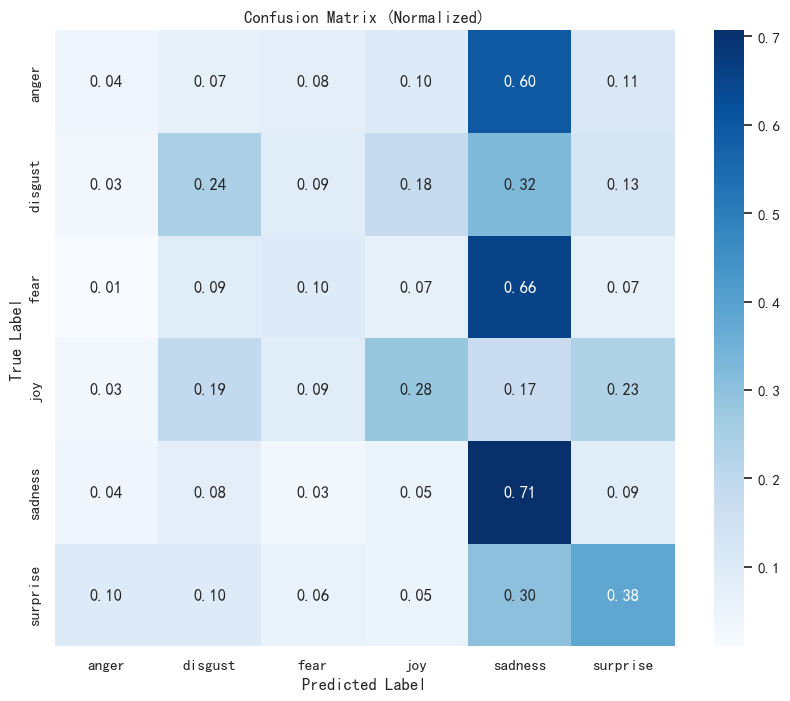

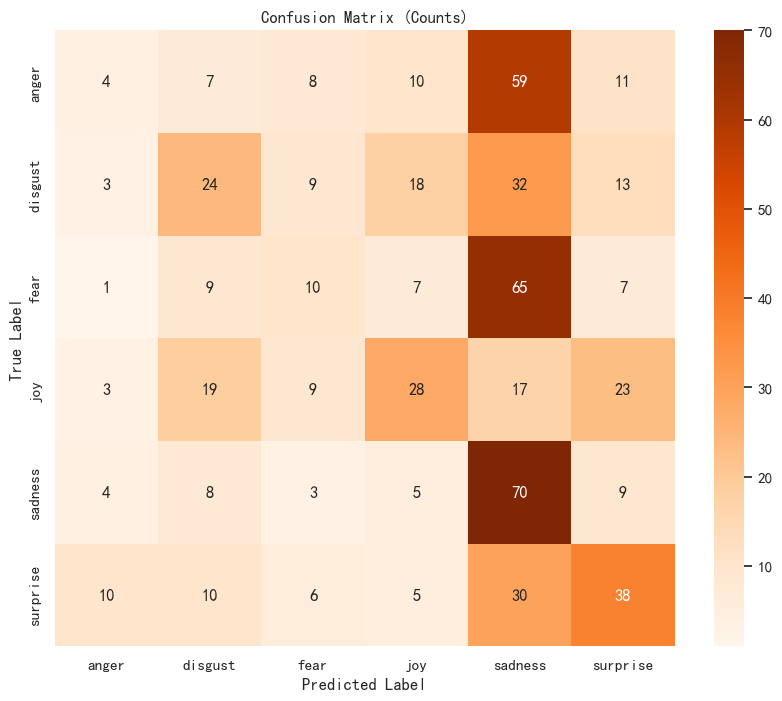

In [7]:
# 6. 可视化混淆矩阵
cm = confusion_matrix(all_targets, all_preds)
# 归一化混淆矩阵，以便观察比例
cm_norm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-10)

plt.figure(figsize=(10, 8), dpi=100)
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix (Normalized)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# 显示原始计数的混淆矩阵
plt.figure(figsize=(10, 8), dpi=100)
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix (Counts)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

Total Correct: 174
Total Incorrect: 420


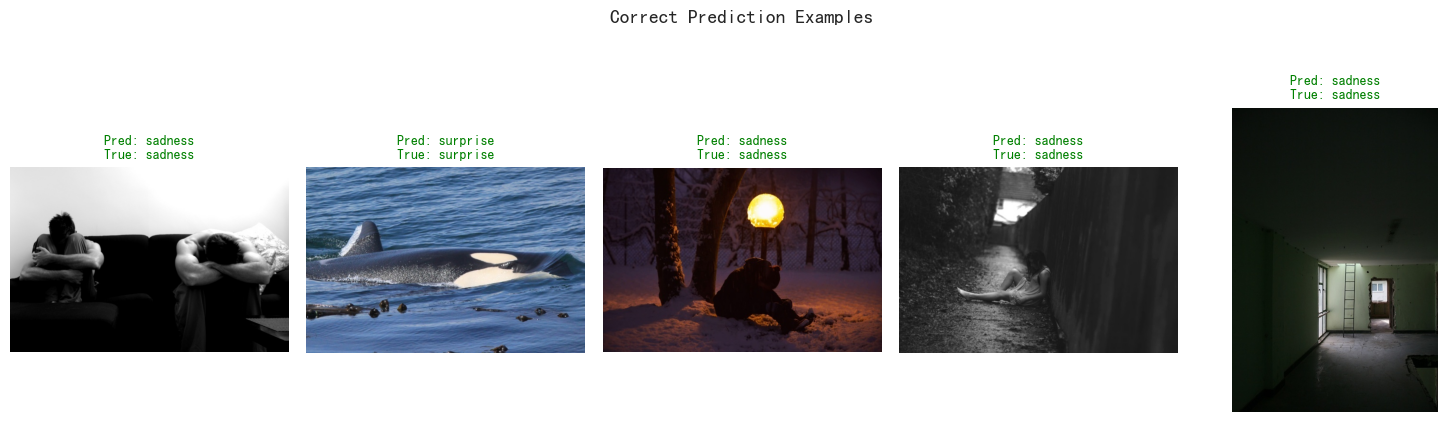

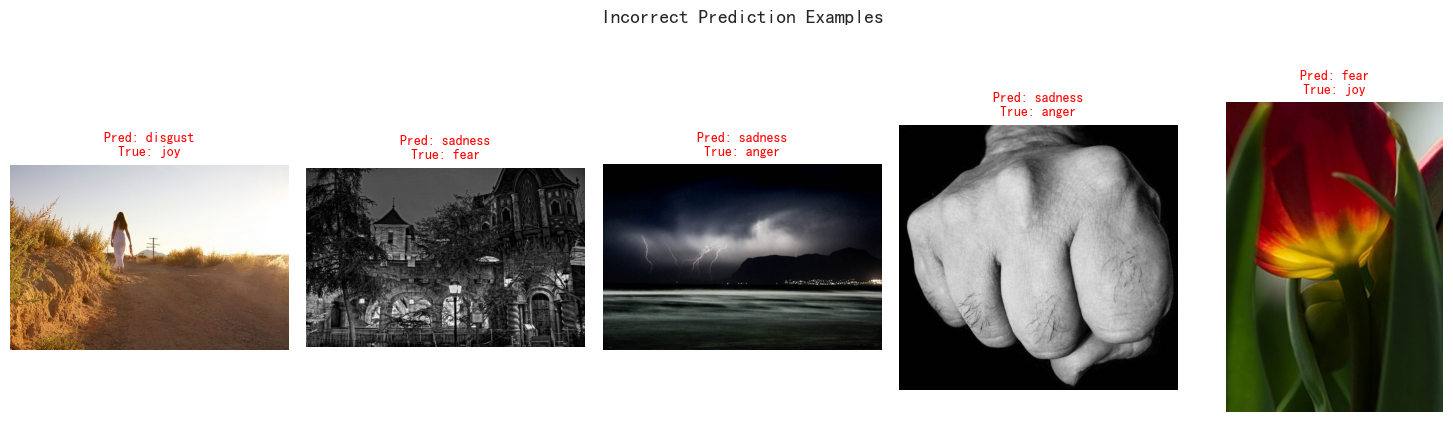

In [8]:
# 7. 可视化预测样本
import random
from PIL import Image

# 获取正确和错误的索引
correct_indices = [i for i, (p, t) in enumerate(zip(all_preds, all_targets)) if p == t]
incorrect_indices = [i for i, (p, t) in enumerate(zip(all_preds, all_targets)) if p != t]

def visualize_samples(indices, title_prefix, num_samples=5):
    """随机可视化指定索引列表中的样本"""
    if not indices:
        print(f"No samples found for {title_prefix}")
        return
        
    # 随机选择样本
    selected_indices = random.sample(indices, min(len(indices), num_samples))
    
    plt.figure(figsize=(15, 4))
    for i, idx in enumerate(selected_indices):
        # 从 dataset 中直接获取原始图片路径
        # 注意：这里假设 dataset 是 GenericImageDataset 且未打乱顺序
        img_path, label = test_loader.dataset.samples[idx]
        
        # 加载原始图片
        try:
            img = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Could not load image {img_path}: {e}")
            continue
            
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.axis('off')
        
        pred_idx = int(all_preds[idx])
        true_idx = int(all_targets[idx])
        
        pred_label = classes[pred_idx]
        true_label = classes[true_idx]
        
        color = 'green' if pred_idx == true_idx else 'red'
        plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color=color, fontsize=10)
        
    plt.suptitle(f"{title_prefix} Examples", fontsize=14, y=1.05)
    plt.tight_layout()
    plt.show()

print(f"Total Correct: {len(correct_indices)}")
print(f"Total Incorrect: {len(incorrect_indices)}")

# 可视化预测正确的样本
visualize_samples(correct_indices, "Correct Prediction", 5)

# 可视化预测错误的样本
visualize_samples(incorrect_indices, "Incorrect Prediction", 5)